In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.tri as tri
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

/home/opotowsky/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 0. Functions

In [2]:
def like_calc(y_sim, y_mes, std):
    like = np.prod(stats.norm.pdf(y_sim, loc=y_mes, scale=std))
    return like

def ll_calc(y_sim, y_mes, std):
    ll = np.sum(stats.norm.logpdf(y_sim, loc=y_mes, scale=std))
    return ll

def unc_calc(y_sim, y_mes, sim_unc_sq, mes_unc_sq):
    unc = ((y_sim - y_mes) / sim_unc_sq)**2 * (sim_unc_sq + mes_unc_sq)
    unc.replace([np.inf, -np.inf], 0, inplace=True)
    unc.fillna(0, inplace = True)
    return np.sqrt(unc.sum(axis=1))

In [74]:
def getstats_unc(trainXY, ll1, ll2, ll3, ll4):
    med1 = trainXY[ll1].median()
    med2 = trainXY[ll2].median()
    med3 = trainXY[ll3].median()
    med4 = trainXY[ll4].median()
    stat1 = stats.describe(trainXY[ll1])
    stat2 = stats.describe(trainXY[ll2])
    stat3 = stats.describe(trainXY[ll3])
    stat4 = stats.describe(trainXY[ll4])
    print(f'5% Median: {med1} \n Stats: {stat1} \n')
    print(f'10% Median: {med2} \n Stats: {stat2} \n')
    print(f'15% Median: {med3} \n Stats: {stat3} \n')
    print(f'20% Median: {med4} \n Stats: {stat4} \n')
    meds = [med1, med2, med3, med4]
    maxs = [stat1.minmax[1], stat2.minmax[1], stat3.minmax[1], stat4.minmax[1]]
    means = [stat1.mean, stat2.mean, stat3.mean, stat4.mean]
    return meds, maxs, means

def getstats_rxtr(trainXY_pwr, trainXY_agr, trainXY_phwr, trainXY, ll):
    medpwr = trainXY_pwr[ll].median()
    medagr = trainXY_agr[ll].median()
    medphwr = trainXY_phwr[ll].median()
    medall = trainXY[ll].median()
    statpwr = stats.describe(trainXY_pwr[ll])
    statagr = stats.describe(trainXY_agr[ll])
    statphwr = stats.describe(trainXY_phwr[ll])
    statall = stats.describe(trainXY[ll])
    print(f'PWR Median: {medpwr} \n Stats: {statpwr} \n')
    print(f'BWR Median: {medagr} \n Stats: {statagr} \n')
    print(f'PHWR Median: {medphwr} \n Stats: {statphwr} \n')
    print(f'All Median: {medall} \n Stats: {statall} \n')
    meds = [medpwr, medagr, medphwr, medall]
    maxs = [statpwr.minmax[1], statagr.minmax[1], statphwr.minmax[1], statall.minmax[1]]
    means = [statpwr.mean, statagr.mean, statphwr.mean, statall.mean]
    return meds, maxs, means

In [4]:
def plotme(plots, pltlabels, zname, vmin, vmax):
    fig = plt.figure(figsize=(17, 14))
    cmap = sns.cubehelix_palette(6, as_cmap=True)
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    surfs = []
    for i, plotXY in enumerate(plots):
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        x = plotXY['Burnup']
        y = plotXY['CoolingTime']
        triang = tri.Triangulation(x, y)
        z = plotXY[zname[i]]
        surf = ax.plot_trisurf(triang, z, linewidth=0.1, norm=norm, cmap=cm.viridis, shade=True)
        surfs.append(surf)
        ax.set_title(pltlabels[i], fontsize=18)
        ax.set_xlabel('Burnup [MWd/MTHM]', fontsize=14, labelpad=15)
        ax.set_ylabel('Cooling Time [days]', fontsize=14, labelpad=15)
        ax.set_zlabel('Likelihood', fontsize=14, labelpad=15)
        #ax.set_xlim(0, 9000)
        ax.set_zlim(vmin, vmax)
    cbar_ax = fig.add_axes([0.00, 0.15, 0.02, 0.7])
    fig.colorbar(surfs[2], cax=cbar_ax)
    plt.tight_layout()
    plt.show()

# 1. Data formatting & LL calculations

In [16]:
pklfile = '../../sims_n_results/nucmoles_opusupdate_aug2019/not-scaled_15nuc.pkl'
XY = pd.read_pickle(pklfile)
XY.reset_index(inplace=True, drop=True)
if 'total' in XY.columns:
    XY.drop('total', axis=1, inplace=True)
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
XY = XY.loc[XY['Burnup'] > 0]

## (a) Get test sample for LL calcs

In [17]:
XY.sample(10)

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,cs137,eu153,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152
9145,29510.35,35.962959,2.000,vver1000,pwr,0.088520,8.4700,7.9020,0.687500,1.8610,8.0090,0.66430,0.111000,16.230,5.5120,5.19100,2.439000,0.019610,1.75500,0.71440
4808,36097.00,0.823024,1.870,w17x17,pwr,0.127700,10.2600,9.1890,1.052000,2.2570,9.7410,0.86320,0.158900,15.620,5.3750,5.69600,3.689000,0.012350,2.18500,0.79480
13847,34027.52,2690.358732,4.010,ge9x9-2,bwr,0.139300,9.6590,8.7800,0.075100,2.9240,7.6650,0.81930,0.080940,17.160,5.2350,4.04200,3.359000,0.017850,2.01700,0.75730
9377,54294.70,0.416829,3.260,vver1000,pwr,0.304100,15.0700,12.4100,2.098000,3.9770,14.3600,1.31800,0.287000,18.920,5.6890,7.63600,6.964000,0.013960,3.29900,0.95400
17790,52201.30,0.000725,1.840,atrium9x9-9,bwr,0.296500,14.5900,11.9400,1.738000,3.7500,13.5900,1.21200,0.216500,13.130,5.2060,4.73600,6.539000,0.007336,2.87700,0.99210
23318,2171.75,369.319843,3.600,vver440,pwr,0.001384,0.6480,0.6522,0.003924,0.1783,0.5890,0.02070,0.000784,5.869,0.2931,0.03972,0.000795,0.016990,0.09575,0.04467
7523,34768.27,1.033514,5.290,s18x18,pwr,0.155700,9.7500,8.7710,1.086000,3.2190,9.3630,0.86800,0.198100,23.840,5.5120,8.95500,3.577000,0.022680,2.19600,0.70200
13949,3039.56,0.000000,4.990,ge9x9-2,bwr,0.001862,0.9056,0.8402,0.009856,0.2722,0.8433,0.02977,0.001604,6.557,0.4715,0.08490,0.002477,0.009709,0.14400,0.07011
24532,12455.33,0.000000,0.711,candu28,phwr,0.014050,3.7590,3.6350,0.074440,0.9540,3.4360,0.14530,0.014800,7.924,2.0050,0.48100,0.068530,0.006410,0.62930,0.36670
17237,23812.33,3326.398117,0.540,atrium9x9-9,bwr,0.056470,6.9810,6.6440,0.018290,1.6550,5.2500,0.44640,0.029060,11.050,4.8410,1.70400,1.166000,0.013160,1.31500,0.65170


In [19]:
# Choosing PWR sample intentionally
sim_idx = 5010
test_sample = XY.loc[XY.index == sim_idx].drop(lbls, axis=1)
test_answer = XY.loc[XY.index == sim_idx, lbls]
test_answer
#test_sample

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
5010,pwr,306.249839,3.22,39382.5,w17x17


In [55]:
XY.drop(10522, inplace=True)

## (b) LL calcs for uncertainty = 5%, 10%, 15%, 20%

In [56]:
fullXY = XY.loc[XY['Burnup'] > 0].copy()
X = fullXY.drop(lbls, axis=1)

In [57]:
uncs = [0.05, 0.10, 0.15, 0.20] 
for unc in uncs:
    like_name = 'Likelihood' + str(unc)
    fullXY[like_name] = X.apply(lambda row: like_calc(row, test_sample.iloc[0], unc*row), axis=1)
    ll_name = 'LogLikelihood_' + str(unc)
    fullXY[ll_name] = X.apply(lambda row: ll_calc(row, test_sample.iloc[0], unc*row), axis=1)
    unc_name = 'LLUncertainty_' + str(unc)
    fullXY[unc_name] = X.apply(lambda row: unc_calc(row, test_sample.iloc[0], (unc*row)**2, (unc*test_sample)**2), axis=1)

In [98]:
#fullXY.to_csv('likelihood_idx10522_15nucs_opusupdate-aug2019.csv')
# two idx options: 10522 and 5010 ...oh and 13287
fullXY = pd.read_csv('likelihood_idx5010_15nucs_opusupdate-aug2019.csv')
fullXY.head()

,Unnamed: 0,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,...,LLUncertainty_0.05,Likelihood0.1,LogLikelihood_0.1,LLUncertainty_0.1,Likelihood0.15,LogLikelihood_0.15,LLUncertainty_0.15,Likelihood0.2,LogLikelihood_0.2,LLUncertainty_0.2
0,1,2006.54,0.000839,0.53,ce14x14,pwr,0.000593,0.6109,0.5142,0.002411,...,2.507794e+10,0.0,-6.276547e+10,1.253897e+10,0.0,-2.789577e+10,8.359314e+09,0.0,-1.569137e+10,6.269485e+09
1,2,2006.54,0.592485,0.53,ce14x14,pwr,0.000600,0.6114,0.5204,0.002411,...,2.507794e+10,0.0,-6.276537e+10,1.253897e+10,0.0,-2.789572e+10,8.359314e+09,0.0,-1.569134e+10,6.269485e+09
2,3,2006.54,1.109213,0.53,ce14x14,pwr,0.000607,0.6114,0.5256,0.002410,...,2.507794e+10,0.0,-6.276530e+10,1.253897e+10,0.0,-2.789569e+10,8.359314e+09,0.0,-1.569132e+10,6.269485e+09
3,4,2006.54,8.460400,0.53,ce14x14,pwr,0.000681,0.6114,0.5759,0.002394,...,2.507794e+10,0.0,-6.276469e+10,1.253897e+10,0.0,-2.789542e+10,8.359314e+09,0.0,-1.569117e+10,6.269485e+09
4,5,2006.54,38.415629,0.53,ce14x14,pwr,0.000806,0.6114,0.6069,0.002329,...,2.507794e+10,0.0,-6.276476e+10,1.253897e+10,0.0,-2.789545e+10,8.359314e+09,0.0,-1.569119e+10,6.269486e+09


# 2. Likelihood for 4 simulated uncertainty values
This is std/scale in logpdf function

In [99]:
l0 = 'Likelihood0.05'
l1 = 'Likelihood0.1'
l2 = 'Likelihood0.15'
l3 = 'Likelihood0.2'
zname = [l0, l1, l2, l3]
uncss = ['5% Uncertainty', '10% Uncertainty', '15% Uncertainty', '20% Uncertainty']

In [100]:
meds, maxs, means = getstats_unc(fullXY, l0, l1, l2, l3)

5% Median: 0.0 
 Stats: DescribeResult(nobs=24677, minmax=(0.0, 172786069.95276383), mean=15740.528343062599, variance=2405881968651.1543, skewness=108.7081624631497, kurtosis=11951.715231638784) 

10% Median: 0.0 
 Stats: DescribeResult(nobs=24677, minmax=(0.0, 37049.47542925062), mean=13.748259700456506, variance=224570.6767923708, skewness=60.232785531959095, kurtosis=4206.240244477996) 

15% Median: 0.0 
 Stats: DescribeResult(nobs=24677, minmax=(0.0, 152.01982756186518), mean=0.18011646751092827, variance=7.984594242233503, skewness=28.739755575078657, kurtosis=1064.0535822386948) 

20% Median: 0.0 
 Stats: DescribeResult(nobs=24677, minmax=(0.0, 2.5697144344688208), mean=0.007832652783482306, variance=0.0054489698784597985, skewness=16.046822571528573, kurtosis=339.7211903022532) 



In [110]:
plotXY = fullXY

In [111]:
x10522 = 2024
y10522 = 2421
x10522_pred = [1964, 1964, 2031, 2010]
y10522_pred = [2503, 2503, 2122, 2690]
x5010 = 39383
y5010 = 306
x5010_pred = [40412, 40412, 39013, 39013]
y5010_pred = [392, 392, 343, 343]

<Figure size 432x288 with 0 Axes>

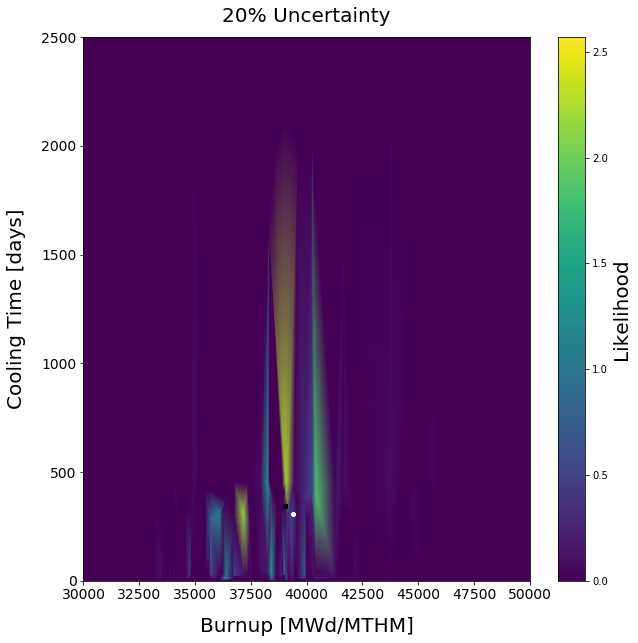

In [115]:
plt.clf()

vmin=0#meds[3]
vmax=maxs[3]

fig = plt.figure(figsize=(10, 10))
cmap = sns.cubehelix_palette(6, as_cmap=True)
norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
ax = fig.add_subplot(111)

x = plotXY['Burnup']
y = plotXY['CoolingTime']
triang = tri.Triangulation(x, y)

z = plotXY[l3]
ax.set_title(uncss[3], fontsize=20, pad=15)

surf = ax.tripcolor(triang, z, norm=norm, cmap=cm.viridis, shading='gouraud')
plt.plot([x5010], [y5010], marker='o', markersize=4, color="white")
plt.plot([x5010_pred[3]], [y5010_pred[3]], marker='s', markersize=4, color="black")

ax.set_xlabel('Burnup [MWd/MTHM]', fontsize=20, labelpad=15)
ax.set_ylabel('Cooling Time [days]', fontsize=20, labelpad=15)
ax.set_xlim(30000, 50000)#(0, 10000)#
ax.set_ylim(0, 2500)#(1500, 3500)#

cbar = fig.colorbar(surf)
cbar.ax.set_ylabel('Likelihood', size=20)
ax.tick_params(labelsize=14)
plt.show()

fig.savefig('../plots/llsurf_idx5010_0.20unc.png', bbox_inches='tight', transparent=True)

# 3. Get LL Pred Results

In [102]:
ll1 = 'LogLikelihood_0.05'
ll2 = 'LogLikelihood_0.1'
ll3 = 'LogLikelihood_0.15'
ll4 = 'LogLikelihood_0.2'
lu1 = 'LLUncertainty_0.05'
lu2 = 'LLUncertainty_0.1'
lu3 = 'LLUncertainty_0.15'
lu4 = 'LLUncertainty_0.2'
lls = [ll1, ll2, ll3, ll4]
lus = [lu1, lu2, lu3, lu4]
uncs = ['5% Uncertainty', '10% Uncertainty', '15% Uncertainty', '20% Uncertainty']

In [103]:
fullXY.head()

,Unnamed: 0,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,...,LLUncertainty_0.05,Likelihood0.1,LogLikelihood_0.1,LLUncertainty_0.1,Likelihood0.15,LogLikelihood_0.15,LLUncertainty_0.15,Likelihood0.2,LogLikelihood_0.2,LLUncertainty_0.2
0,1,2006.54,0.000839,0.53,ce14x14,pwr,0.000593,0.6109,0.5142,0.002411,...,2.507794e+10,0.0,-6.276547e+10,1.253897e+10,0.0,-2.789577e+10,8.359314e+09,0.0,-1.569137e+10,6.269485e+09
1,2,2006.54,0.592485,0.53,ce14x14,pwr,0.000600,0.6114,0.5204,0.002411,...,2.507794e+10,0.0,-6.276537e+10,1.253897e+10,0.0,-2.789572e+10,8.359314e+09,0.0,-1.569134e+10,6.269485e+09
2,3,2006.54,1.109213,0.53,ce14x14,pwr,0.000607,0.6114,0.5256,0.002410,...,2.507794e+10,0.0,-6.276530e+10,1.253897e+10,0.0,-2.789569e+10,8.359314e+09,0.0,-1.569132e+10,6.269485e+09
3,4,2006.54,8.460400,0.53,ce14x14,pwr,0.000681,0.6114,0.5759,0.002394,...,2.507794e+10,0.0,-6.276469e+10,1.253897e+10,0.0,-2.789542e+10,8.359314e+09,0.0,-1.569117e+10,6.269485e+09
4,5,2006.54,38.415629,0.53,ce14x14,pwr,0.000806,0.6114,0.6069,0.002329,...,2.507794e+10,0.0,-6.276476e+10,1.253897e+10,0.0,-2.789545e+10,8.359314e+09,0.0,-1.569119e+10,6.269486e+09


## Reactor Prediction

In [104]:
data = {}
idx = {}
for ll, lu in zip(lls, lus):
    max_pwr = fullXY[ll].loc[fullXY['ReactorType'] == 'pwr'].max()
    idx_pwr = fullXY[ll].loc[fullXY['ReactorType'] == 'pwr'].idxmax()
    unc_pwr = float(fullXY[lu].loc[fullXY.index == idx_pwr])
    max_bwr = fullXY[ll].loc[fullXY['ReactorType'] == 'bwr'].max()
    idx_bwr = fullXY[ll].loc[fullXY['ReactorType'] == 'bwr'].idxmax()
    unc_bwr = float(fullXY[lu].loc[fullXY.index == idx_bwr])
    max_phwr = fullXY[ll].loc[fullXY['ReactorType'] == 'phwr'].max()
    idx_phwr = fullXY[ll].loc[fullXY['ReactorType'] == 'phwr'].idxmax()
    unc_phwr = float(fullXY[lu].loc[fullXY.index == idx_phwr])
    data[ll] = [max_pwr, max_bwr, max_phwr]
    data[lu] = [unc_pwr, unc_bwr, unc_phwr]
    idx[ll] = [idx_pwr, idx_bwr, idx_phwr]
rxtr = pd.DataFrame(data, columns=[ll1, lu1, ll2, lu2, ll3, lu3, ll4, lu4], index=['pwr', 'bwr', 'phwr'])
rxtr

,LogLikelihood_0.05,LLUncertainty_0.05,LogLikelihood_0.1,LLUncertainty_0.1,LogLikelihood_0.15,LLUncertainty_0.15,LogLikelihood_0.2,LLUncertainty_0.2
pwr,18.967565,3.254686,10.520009,1.627343,5.024011,1.508366,0.943795,1.131275
bwr,2.344970,8.902489,6.566396,4.451245,3.208129,3.008143,-0.083764,2.718742
phwr,-451595.105989,37524.646638,-112875.317334,18762.323319,-50153.587113,12508.215546,-28203.168076,9381.161659


In [105]:
idx

{'LogLikelihood_0.05': [2831, 21324, 24672],
 'LogLikelihood_0.1': [2831, 21324, 24672],
 'LogLikelihood_0.15': [3893, 21315, 24672],
 'LogLikelihood_0.2': [3893, 14034, 24672]}

In [106]:
for ll in lls:
    print(ll)
    for i, index in enumerate(idx[ll]):
        print(fullXY.loc[fullXY.index == idx[ll][i], ['ReactorType', 'Burnup', 'CoolingTime']])

LogLikelihood_0.05
     ReactorType    Burnup  CoolingTime
2831         pwr  40412.05   392.313045
      ReactorType    Burnup  CoolingTime
21324         bwr  37521.68    34.458875
      ReactorType    Burnup  CoolingTime
24672        phwr  13678.58     5.662128
LogLikelihood_0.1
     ReactorType    Burnup  CoolingTime
2831         pwr  40412.05   392.313045
      ReactorType    Burnup  CoolingTime
21324         bwr  37521.68    34.458875
      ReactorType    Burnup  CoolingTime
24672        phwr  13678.58     5.662128
LogLikelihood_0.15
     ReactorType    Burnup  CoolingTime
3893         pwr  39013.38   343.237299
      ReactorType    Burnup  CoolingTime
21315         bwr  37361.88    34.458875
      ReactorType    Burnup  CoolingTime
24672        phwr  13678.58     5.662128
LogLikelihood_0.2
     ReactorType    Burnup  CoolingTime
3893         pwr  39013.38   343.237299
      ReactorType    Burnup  CoolingTime
14034         bwr  36727.11    37.125682
      ReactorType    Burnup  Coo

In [71]:
max_tot = fullXY[ll1].max()
idx = fullXY[ll1].idxmax()
max_tot, idx

(68.62441895096356, 20912)

In [94]:
sim_idx = 13379
top_answer = fullXY.loc[fullXY.index == sim_idx, lbls]
top_answer

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
13379,bwr,2690.358732,2.88,2010.26,ge9x9-2


In [90]:
sim_idx = 10522
top_answer = XY.loc[XY.index == sim_idx, lbls]
top_answer

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
10522,bwr,2421.282899,2.89,2024.53,ge7x7-0


In [82]:
xy = pd.read_csv('likelihood_idx5010_15nucs_opusupdate-aug2019.csv')

In [83]:
xy.head()

,Unnamed: 0,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,...,LLUncertainty_0.05,Likelihood0.1,LogLikelihood_0.1,LLUncertainty_0.1,Likelihood0.15,LogLikelihood_0.15,LLUncertainty_0.15,Likelihood0.2,LogLikelihood_0.2,LLUncertainty_0.2
0,1,2006.54,0.000839,0.53,ce14x14,pwr,0.000593,0.6109,0.5142,0.002411,...,2.507794e+10,0.0,-6.276547e+10,1.253897e+10,0.0,-2.789577e+10,8.359314e+09,0.0,-1.569137e+10,6.269485e+09
1,2,2006.54,0.592485,0.53,ce14x14,pwr,0.000600,0.6114,0.5204,0.002411,...,2.507794e+10,0.0,-6.276537e+10,1.253897e+10,0.0,-2.789572e+10,8.359314e+09,0.0,-1.569134e+10,6.269485e+09
2,3,2006.54,1.109213,0.53,ce14x14,pwr,0.000607,0.6114,0.5256,0.002410,...,2.507794e+10,0.0,-6.276530e+10,1.253897e+10,0.0,-2.789569e+10,8.359314e+09,0.0,-1.569132e+10,6.269485e+09
3,4,2006.54,8.460400,0.53,ce14x14,pwr,0.000681,0.6114,0.5759,0.002394,...,2.507794e+10,0.0,-6.276469e+10,1.253897e+10,0.0,-2.789542e+10,8.359314e+09,0.0,-1.569117e+10,6.269485e+09
4,5,2006.54,38.415629,0.53,ce14x14,pwr,0.000806,0.6114,0.6069,0.002329,...,2.507794e+10,0.0,-6.276476e+10,1.253897e+10,0.0,-2.789545e+10,8.359314e+09,0.0,-1.569119e+10,6.269486e+09


In [85]:
max_tot = xy[ll1].max()
idx = xy[ll1].idxmax()
max_tot, idx

(18.967564797385485, 2831)

In [86]:
sim_idx = 2831
top_answer = xy.loc[xy.index == sim_idx, lbls]
top_answer

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
2831,pwr,392.313045,3.07,40412.05,w14x14
